The default tensorflow version on Colab is still 1.*x* but we can request to use TensorFlow 2.*x*

In [0]:
%tensorflow_version 2.x

from datetime import datetime

from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf 

assert(tf.__version__ == "2.1.0")

We're going to attempt to classify the MNIST fashion dataset, which we can load from a Google Cloud bucket using `tf.keras.datasets.fashion_mnist.load_data()`

In [4]:
fashion = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

4423680/4422102 [==============================] - 0s 0us/step


It's nice to define constants at the top of the file, so let's do that here and maintain this as the source of truth for global/notebook constants

---



In [0]:
LEAKY_RELU_ALPHA = 0.2
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
SIG_DIGITS = 5

Since we are not going to use Keras in this implementation, we have to define our own layers using `tf.nn`. The general approach is:

1. Flatten the input from a 28 x 28 matrix to a 784 x 1 vector
1. Implement a dense, fully connected, layer of nodes that multiplies the inputs by the weights
1. Design a dense, fully connected, dropout layer as a regularization approach
1. Make the output of the network be a softmax over a dense layer

In [0]:
@tf.function
def flatten(inputs):
  """ 
  A flattening layer that transforms a given input to the shape of 
  :param inputs: input of the layer
  """
  return tf.keras.backend.flatten(inputs)

@tf.function
def dense(inputs, weights):
  """ 
  A dense layer that represents a typical network layer of a neural network. Meant to replace 
  tf.keras.Dense
  :param inputs: input of the layer, transpose has to match the shape of the weights
  :param weights: weights of the current layer
  :return: sigmoid activations
  """
  mult = tf.matmul([inputs], weights)
  return tf.nn.sigmoid(mult)

@tf.function
def dropout(inputs, weights):
    """ 
    A droput layer that represents a typical network layer in a neural network. Meant to replace 
    tf.keras.Dropout
    :param inputs: input of the layer, transpose has to match the shape of the weights
    :param weights: weights of the current layer
    :return: tf.nn function
    """
    mult = tf.matmul(inputs, weights)
    x = tf.nn.leaky_relu(mult, alpha=LEAKY_RELU_ALPHA)
    return tf.nn.dropout(x, rate=DROPOUT_RATE)

@tf.function
def softmax(inputs, weights):
  """
  A softmax layer that represents the output layer of the network built in this notebook. It is 
  supposed to replace tf.keras.dense with softmax
  :param inputs: the inputs of the layer
  :param weights: weights of the current layer
  :return: softmax vector
  """
  mult = tf.matmul(inputs, weights)
  return tf.nn.softmax(mult)

Now that we have defined the types of layers, we have to initialize all the variables of the model. Namely, we have to initialize the weights as TensorFlow trainable variables. In addition, we need the shapes of the input and output for the respective layers. Notice that we have to use matrix multiplication compatible layer (columns have to match number of rows) shapes. 

In [0]:
shapes = [
    [784, 32],  # flattened pictures from 28x28 to 784, dense layer of 32 nodes with 32 output activations
    [32, 32],  # dropout layer of 32 nodes, output of 32 activations
    [32, 10]  # softmax output layer of 10 nodes, 1 for each category
]

# Initialization of weights from a standard normal
initializer = tf.random_normal_initializer()
def get_weight(shape, name):
    """ Creates and returns a TensorFlow variable with the given shape and name """
    return tf.Variable(initializer(shape=shape), name=name, trainable=True, dtype=tf.float32)

# Array of weights that represent the weights of the network
weights = []
for i in range(len(shapes)):
    weights.append(get_weight(shapes[i], 'weight_{}'.format(i)))

Now that we have the components ready, we can create a model. In this case, the model is just a linear pass through the layer functions (flatten, dense, dropout/dense, softmax)

In [0]:
def model(x):
    """ Model represents the network create from the above-defined components. It performs a 
    single forward pass using the input x and returns the last layer's output """
    r = flatten(x)
    r = tf.cast(r, dtype=tf.float32)
    r = dense(r, weights[0])
    r = dropout(r, weights[1])
    r = softmax(r, weights[2])
    return r

We also need to define the function that defines the model loss, which is the function the model is trying to minimize. In this case, we will use sparse categorical cross-entropy

In [0]:
def loss(pred, target):
    """ Loss function that measures the different between predicted and target using categorical
    cross-entropy. This is what the model is trying to minimize  """
    # SCC assumes the predicted encodes a probability distribution (in our case, from softmax) 
    return tf.losses.sparse_categorical_crossentropy(target, pred)

Now we are ready to define the training step function, which taken an input, passes it through the network, obtains the loss, and applies the gradients. In addition, we will keep track of the epoch training and validation accuracy along with training and validation loss

In [10]:
optimizer = tf.optimizers.Adam(LEARNING_RATE)

def train_step(inputs, outputs):
    """ 
    Training step that performs a series of predictions, computed the batch loss, and applies gradients
    :param model: TensorFlow model
    :param inputs: the series of inputs to perform predictions on
    :param outputs: the desired output mapping of the given inputs
    :return: 1 if the prediction was correct 0 otherwise, loss
    """
    with tf.GradientTape() as tape:
        guess = model(inputs)
        current_loss = loss(guess, outputs)
        gradients = tape.gradient(current_loss, weights)
        optimizer.apply_gradients(zip(gradients, weights))
        max_idx = np.argmax(guess)
        if max_idx == outputs:
            return 1, current_loss
        return 0, current_loss

def validate():
    """ Executes the validation step of the model and returns the accuracy associated with the
    performance of the model """
    acc = 0
    validation_loss = 0
    trials = len(x_test)
    for ti, tl in zip(x_test, y_test):
        guess = model(ti)
        validation_loss += loss(guess, tl).numpy()[0]
        max_idx = np.argmax(guess)
        if max_idx == tl:
            acc += 1
    return acc/trials, validation_loss/trials

def train():
    """ Executes a single training step over all the given images """
    acc = 0
    train_loss = 0
    trials = len(x_train)
    for ti, tl in zip(x_train, y_train):
        correct, curr_loss = train_step(ti, tl)
        acc += correct
        train_loss += curr_loss.numpy()[0]
    return acc/trials, train_loss/trials

validations = []
valid_losses = []
accuracies = []
losses = []
total = len(x_train)
start = datetime.now()
for epoch in range(NUM_EPOCHS):
    print("Epoch: {}/{}".format(epoch + 1, NUM_EPOCHS))
    test_ratio, test_loss_ratio = train()
    valid_ratio, valid_loss_ratio = validate()

    test_acc = round(test_ratio, SIG_DIGITS)
    test_loss = round(test_loss_ratio, SIG_DIGITS)
    valid_acc = round(valid_ratio, SIG_DIGITS)
    valid_loss = round(valid_loss_ratio, SIG_DIGITS)

    accuracies.append((epoch, test_ratio))
    losses.append((epoch, test_loss))
    validations.append((epoch, valid_ratio))
    valid_losses.append((epoch, valid_loss_ratio))

    print("Test acc: {}\t\tTest loss: {}\t\tValid acc: {}\t\tValid loss: {}".format(test_acc, test_loss, valid_acc, valid_loss))
end = datetime.now()
time_delta = (end - start).total_seconds()

Epoch: 1/50
Test acc: 0.7967		Test loss: 0.55358		Valid acc: 0.8343		Valid loss: 0.466
Epoch: 2/50
Test acc: 0.84368		Test loss: 0.43656		Valid acc: 0.8302		Valid loss: 0.4775
Epoch: 3/50
Test acc: 0.85492		Test loss: 0.40598		Valid acc: 0.8475		Valid loss: 0.42913
Epoch: 4/50
Test acc: 0.8599		Test loss: 0.38935		Valid acc: 0.845		Valid loss: 0.42587
Epoch: 5/50
Test acc: 0.8646		Test loss: 0.37522		Valid acc: 0.8519		Valid loss: 0.42811
Epoch: 6/50
Test acc: 0.86812		Test loss: 0.36478		Valid acc: 0.8487		Valid loss: 0.43
Epoch: 7/50
Test acc: 0.86995		Test loss: 0.359		Valid acc: 0.8464		Valid loss: 0.45214
Epoch: 8/50
Test acc: 0.87277		Test loss: 0.35072		Valid acc: 0.8402		Valid loss: 0.4678
Epoch: 9/50
Test acc: 0.87607		Test loss: 0.34384		Valid acc: 0.8529		Valid loss: 0.43373
Epoch: 10/50
Test acc: 0.87708		Test loss: 0.34125		Valid acc: 0.857		Valid loss: 0.41739
Epoch: 11/50
Test acc: 0.8777		Test loss: 0.3397		Valid acc: 0.8484		Valid loss: 0.44702
Epoch: 12/50
Test acc: 0

We can plot the loss and accuracy results using matplotlib. Specifically, we can plot the training and validation accuracy together, similar to how TensorFlow reports results. We can do the same for training and validation loss

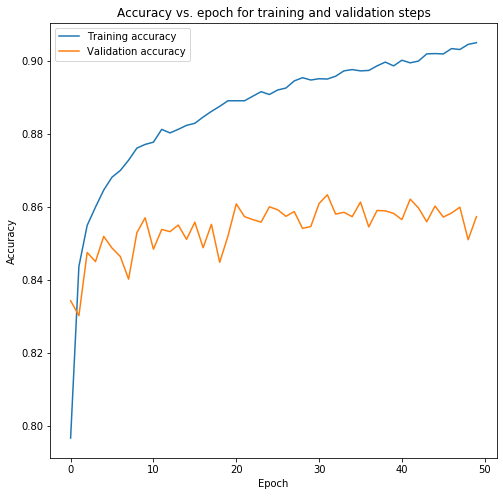

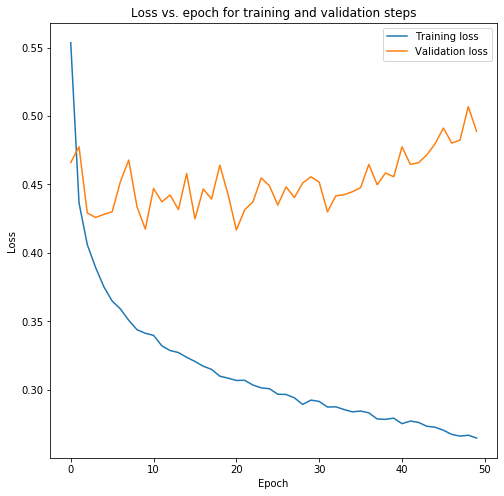

In [21]:
def plot(training, validation, train_label="", valid_label="", ylabel="", title="", filename=""):
    """ Creates two plots of the training and validation results (accuracy, loss) """
    fig = plt.figure(figsize=(8, 8))
    train_x, train_y = [], []
    for x, y in training:
        train_x.append(x)
        train_y.append(y)
    valid_x, valid_y = [], []
    for x, y in validation:
        valid_x.append(x)
        valid_y.append(y)
    plt.title(title)
    plt.plot(train_x, train_y, label=train_label)
    plt.plot(valid_x, valid_y, label=valid_label)
    plt.ylabel(ylabel)
    plt.xlabel("Epoch")
    plt.legend()
    name = "{}.pdf".format(filename)
    plt.savefig(name, bbox_inches='tight')
    files.download(name)

plot(accuracies, validations, 
     train_label="Training accuracy",
     valid_label="Validation accuracy",
     ylabel="Accuracy",
     title="Accuracy vs. epoch for training and validation steps",
     filename="train_valid_acc")
plot(losses, valid_losses,
     train_label="Training loss",
     valid_label="Validation loss",
     ylabel="Loss",
     title="Loss vs. epoch for training and validation steps",
     filename="train_valid_loss")